In [11]:
import momi
import logging
logging.basicConfig(level=logging.INFO,
                    filename="tutorial.log")

In [109]:
model = momi.DemographicModel(N_e=5e4, gen_time=29, muts_per_gen=1.25e-8)

model.add_leaf("S2")
model.add_leaf("Adm")
model.add_leaf("S1")

# at 45kya Adm receive a 30% pulse from S1
model.move_lineages("Adm", "GhostS1", t=4.5e4, p=.3)
# at 55kya GhostS1 joins onto S1
model.move_lineages("GhostS1", "S1", t=5.5e4)

# at 85 kya Adm joins onto S2; S2 is set to size N=1e5
model.move_lineages("Adm", "S2", t=8.5e4)

# at 500 kya S2 joins onto S1
model.move_lineages("S2", "S1", t=5e5)

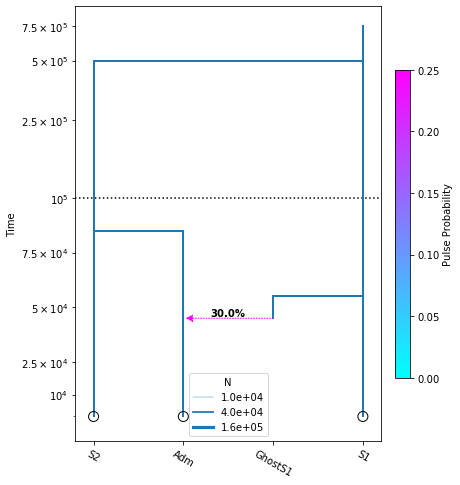

In [110]:
%matplotlib inline

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, ["S2", "Adm", "GhostS1", "S1"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,.25))

In [111]:
# simulating Data
recoms_per_gen = 1.25e-8
bases_per_locus = int(5e5)
n_loci = 20
ploidy = 2

# n_alleles per population (n_individuals = n_alleles / ploidy)
sampled_n_dict = {"S1":8, "S2":8, "Adm":8}

# create data directory if it doesn't exist
!mkdir -p tutorial_datasets/

# simulate 20 "chromosomes", saving each in a separate vcf file
for chrom in range(1, n_loci+1):
      model.simulate_vcf(
            f"tutorial_datasets/{chrom}",
            recoms_per_gen=recoms_per_gen,
            length=bases_per_locus,
            chrom_name=f"chr{chrom}",
            ploidy=ploidy,
            random_seed=1234+chrom,
            sampled_n_dict=sampled_n_dict,
            force=True)

# Read VCF and compute SFS

In [112]:
# a dict mapping samples to populations
ind2pop = {}
for pop, n in sampled_n_dict.items():
    for i in range(int(n / ploidy)):
        # in the vcf, samples are named like YRI_0, YRI_1, CHB_0, etc
        ind2pop["{}_{}".format(pop, i)] = pop

with open("tutorial_datasets/ind2pop.txt", "w") as f:
    for i, p in ind2pop.items():
        print(i, p, sep="\t", file=f)

!cat tutorial_datasets/ind2pop.txt

S1_0	S1
S1_1	S1
S1_2	S1
S1_3	S1
S2_0	S2
S2_1	S2
S2_2	S2
S2_3	S2
Adm_0	Adm
Adm_1	Adm
Adm_2	Adm
Adm_3	Adm


In [113]:
%%sh
for chrom in `seq 1 20`;
do
    python -m momi.read_vcf \
           tutorial_datasets/$chrom.vcf.gz tutorial_datasets/ind2pop.txt \
           tutorial_datasets/$chrom.snpAlleleCounts.gz \
           --bed tutorial_datasets/$chrom.bed
done

In [114]:
%%sh
python -m momi.extract_sfs tutorial_datasets/sfs.gz 100 tutorial_datasets/*.snpAlleleCounts.gz

In [115]:
sfs = momi.Sfs.load("tutorial_datasets/sfs.gz")

# Inference

In [129]:
no_pulse_model = momi.DemographicModel(N_e=5e4, gen_time=29, muts_per_gen=1.25e-8)
no_pulse_model.set_data(sfs)

In [130]:
# random initial value; user-specified lower bound
no_pulse_model.add_time_param("t_Adm_S2", lower=1e4)

no_pulse_model.add_leaf("Adm")
no_pulse_model.add_leaf("S2")
no_pulse_model.move_lineages("Adm", "S2", t="t_Adm_S2")

no_pulse_model.optimize(method="TNC")
no_pulse_model.get_params()

ParamsDict({'t_Adm_S2': 129400.93715505535})

In [131]:
no_pulse_model.add_leaf("S1")
no_pulse_model.add_time_param("t_anc", lower=5e4, lower_constraints=["t_Adm_S2"])
no_pulse_model.move_lineages("S2", "S1", t="t_anc")

In [134]:
add_pulse_model = no_pulse_model.copy()
add_pulse_model.add_pulse_param("p_pulse")

add_pulse_model.move_lineages(
    "Adm", "GhostS1", t=4.5e4, p="p_pulse")

add_pulse_model.add_time_param(
    "t_ghost", lower=5e4,
    upper_constraints=["t_anc"])
add_pulse_model.move_lineages(
    "GhostS1", "S1", t="t_ghost")


In [121]:
add_pulse_model = no_pulse_model.copy()
add_pulse_model.add_pulse_param("p_pulse")
add_pulse_model.add_time_param(
    "t_pulse", upper_constraints=["t_Adm_S2"])

add_pulse_model.move_lineages(
    "Adm", "GhostS1", t="t_pulse", p="p_pulse")

add_pulse_model.add_time_param(
    "t_ghost", lower=5e4,
    lower_constraints=["t_pulse"], upper_constraints=["t_anc"])
add_pulse_model.move_lineages(
    "GhostS1", "S1", t="t_ghost")


In [135]:
results = []
n_runs = 1
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    add_pulse_model.set_params(
        # parameters inherited from no_pulse_model are set to their previous values
        no_pulse_model.get_params(),
        # other parmaeters are set to random initial values
        randomize=True)

    results.append(add_pulse_model.optimize(options={"maxiter":200}))

# sort results according to log likelihood, pick the best (largest) one
best_result = sorted(results, key=lambda r: r.log_likelihood)[-1]

add_pulse_model.set_params(best_result.parameters)
best_result

Starting run 1 out of 1...


            fun: 0.007783395029951479
            jac: array([3.07980096e-10, 8.76014504e-13, 8.51892011e-06, 2.21402471e-06])
  kl_divergence: 0.007783395029951479
 log_likelihood: -515888.8574209523
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 51
            nit: 12
     parameters: ParamsDict({'t_Adm_S2': 91055.74230309518, 't_anc': 500622.0970171866, 'p_pulse': 0.28566616273579515, 't_ghost': 53229.51743664499})
         status: 1
        success: True
              x: array([ 8.10557423e+04,  4.09566355e+05, -9.16526546e-01, -4.93110374e+00])

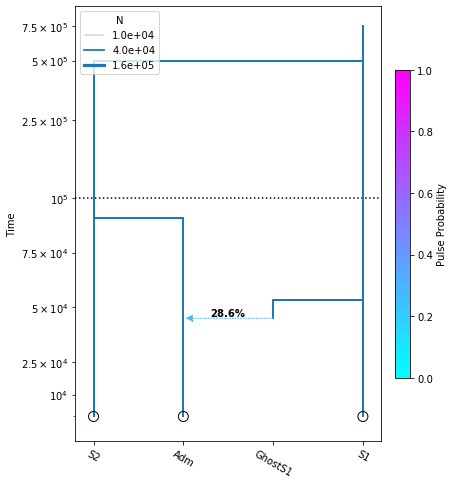

In [136]:
# plot the model
fig = momi.DemographyPlot(
    add_pulse_model, ["S2", "Adm", "GhostS1", "S1"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks)
# put legend in upper left corner
fig.draw_N_legend(loc="upper left")